In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage

## Compute the Camera Calibration

Not all corners found!
Not all corners found!
Not all corners found!


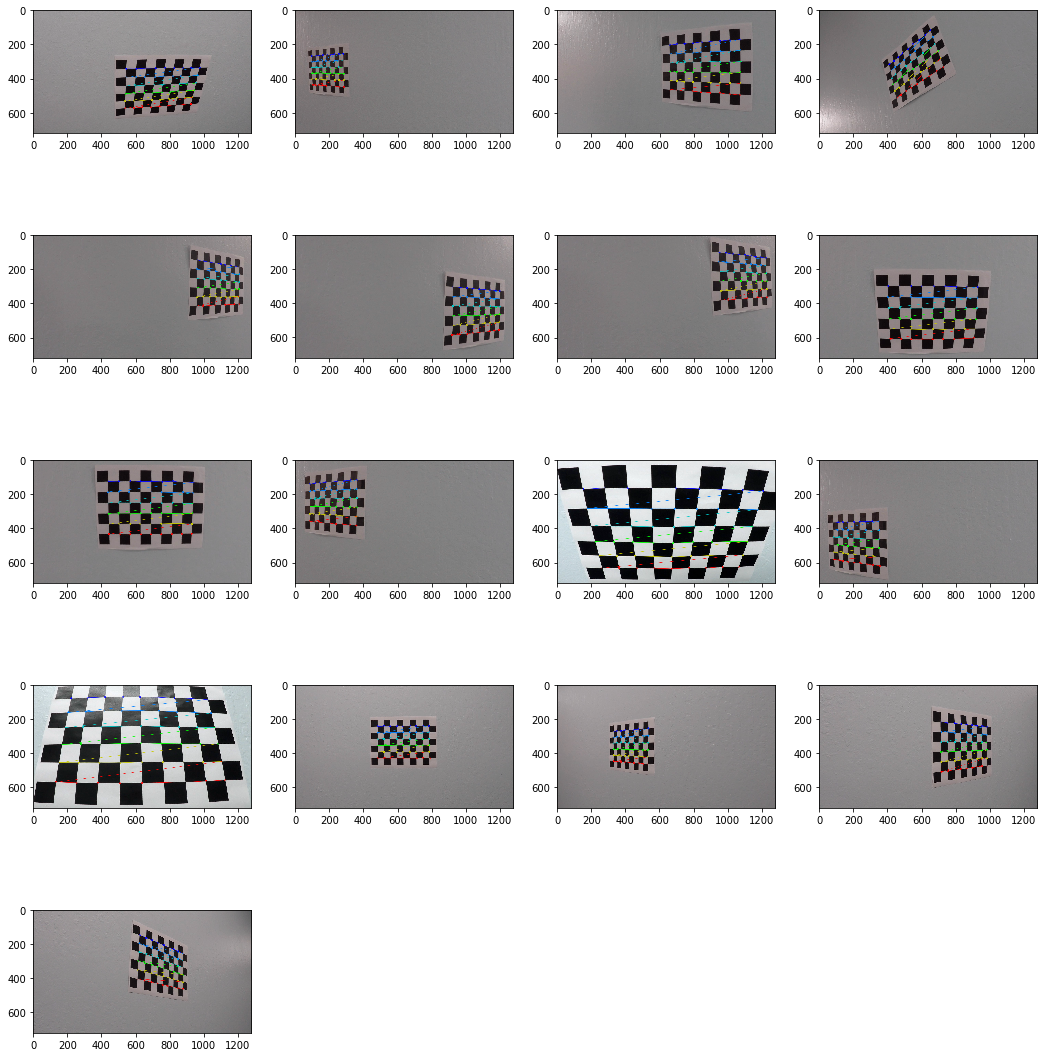

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners

plt.figure(1,figsize = (18,20))
plot_counter = 1

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.subplot(5,4,plot_counter)
        plt.imshow(img)
        plot_counter += 1
    else:
        print('Not all corners found!')

In [3]:
#Compute Camera Calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

def undist_img(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [4]:
def read_img(name):
    bgr_img = cv2.imread(name)
    return cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

## Test the Camera Calibration

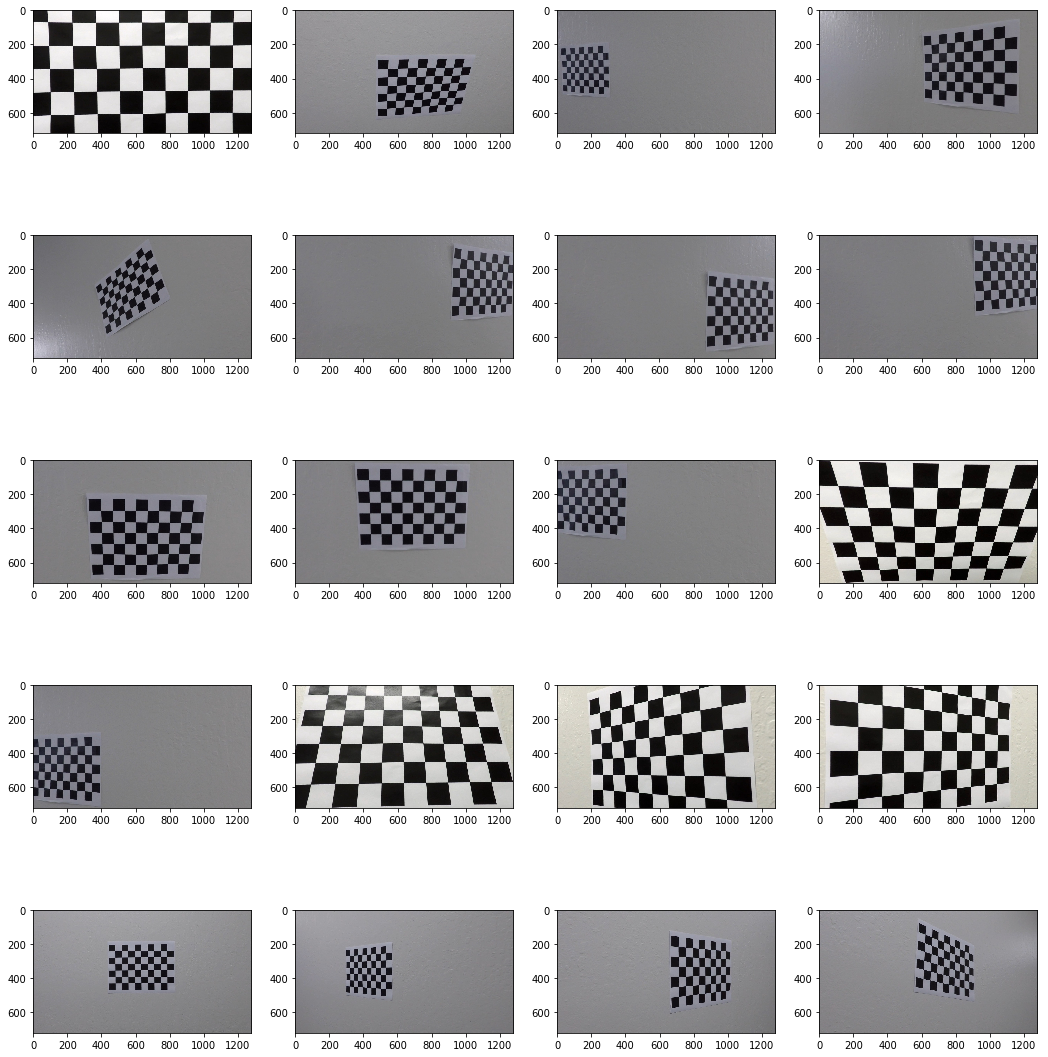

In [5]:
#Test the distortion correction

plt.figure(1, figsize = (18,20))
plot_counter = 1

for fname in images:
    img = read_img(fname)
    u_img = undist_img(img)
    plt.subplot(5,4,plot_counter)
    plt.imshow(u_img)
    plot_counter += 1

## Define the Projective Transform

In [6]:
#Define the mask

dst = np.float32([[205,720],[1280,0],[0,0],[1075,720]])

delta_x_t = 120
delta_x_b = 575
delta_y = 460

src = np.float32([[640-delta_x_b,720],[640+delta_x_t,delta_y],[640-delta_x_t,delta_y],[640+delta_x_b,720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
def warp_image(img):
    return cv2.warpPerspective(img, M, (1280,720), flags=cv2.INTER_LINEAR)

## Define the Lane Finding Pipeline

In [7]:
#This function was provided by udactiy, it is used to identify the lane lines of the first frame of the video

def find_lines_function(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return [left_fit,right_fit]

In [8]:
#Size of the image
x_dim = 1280
y_dim = 720

image_counter = 0

#Width of the corridor which is taken into account around the previous lane line
corr_width = 55

#Tresholds to define which pixel belong to a lane line
bright_th = 190
bright_min_th = 170
sobel_th = 330

#Minimum number of pixels which should be used to fit a line
min_number_try_fit = 40

#Rate on how fast to adapt the lane lines from frame to frame
belive = 0.5

list_coeff_l = []
list_coeff_r = []

#If draw_lane_lines is activate the function prodcues the original video combined with the computed lane lines
#If draw_lane_lines is set to false the function prodcues a video of the input of the fitting procedure
draw_lane_lines = True

#This function defines the pipeline which is used to draw the lane lines on the video 
def pipeline_advanced(img):
    global image_counter
    global coeff_l
    global coeff_r
    
    #Undistort the image
    img = undist_img(img)
   
    #Combine R and S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    R = np.maximum(img[:,:,0],hls[:,:,2])
    
    #Warp the image
    R = warp_image(R)
    
    #If this is the first image of the video:
    #Use the function provided from the course notes to find the initial lines
    if(image_counter == 0):
        #Define binary image for the find_lines_function
        R_bin = np.zeros_like(R)
        sobelx = cv2.Sobel(R, cv2.CV_64F, 1, 0,ksize = 5) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        R_bin = ((R >= bright_th)|((abs_sobelx>sobel_th) & (R> bright_min_th ))) 
        
        coeff_l,coeff_r = find_lines_function(R_bin)
    
    image_counter += 1
    
    #Use only points to fit the line which lie inside a corridor of the line from the previous picture
    points_img_left = np.zeros_like(R)
    points_img_right = np.zeros_like(R)
        
    #Define the two corridors around the left and right line from the previous picture    
    ploty = np.linspace(0,y_dim -1, y_dim)
    
    left_fitx = coeff_l[0]*ploty**2 + coeff_l[1]*ploty + coeff_l[2]
    right_fitx = coeff_r[0]*ploty**2 + coeff_r[1]*ploty + coeff_r[2]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])    
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])    

    pts_int_left = pts_left.astype(int)
    pts_int_right = pts_right.astype(int)

    pts_int_left = pts_int_left[0,:,:]
    pts_int_right = pts_int_right[0,:,:]

    feasible_index_left = ((0<=pts_int_left[:,1]) & (pts_int_left[:,1]<y_dim) & (0<=pts_int_left[:,0]) & (pts_int_left[:,0]<x_dim))
    feasible_index_right = ((0<=pts_int_right[:,1]) & (pts_int_right[:,1]<y_dim) & (0<=pts_int_right[:,0]) & (pts_int_right[:,0]<x_dim))

    image_with_line_left = np.zeros((y_dim,x_dim),dtype = np.int32)
    image_with_line_right = np.zeros((y_dim,x_dim),dtype = np.int32)

    image_with_line_left[pts_int_left[feasible_index_left][:,1],pts_int_left[feasible_index_left][:,0]] = 1
    image_with_line_right[pts_int_right[feasible_index_right][:,1],pts_int_right[feasible_index_right][:,0]] = 1

    image_with_corridor_left = ndimage.maximum_filter(image_with_line_left,corr_width)
    image_with_corridor_right = ndimage.maximum_filter(image_with_line_right,corr_width)

    #Next identify which points may belong to lane lines
    focus_l = R*(image_with_corridor_left==1)
    focus_r = R*(image_with_corridor_right==1)

    sobel_focus_x_l = cv2.Sobel(focus_l, cv2.CV_64F, 1, 0,ksize = 5)
    sobel_focus_x_r = cv2.Sobel(focus_r, cv2.CV_64F, 1, 0,ksize = 5)
    
    abs_sobel_focus_l = np.abs(sobel_focus_x_l)
    abs_sobel_focus_r = np.abs(sobel_focus_x_r)
    
    #We have to take a smaller corridor, since the sobel operator marks the boundaries of the larger corridor
    image_with_corridor_left_smaller = ndimage.maximum_filter(image_with_line_left,corr_width-4)
    image_with_corridor_right_smaller = ndimage.maximum_filter(image_with_line_right,corr_width-4)
    
    #The following rule is used to decide which pixel belongs to a lane line
    candidates_left =  ((image_with_corridor_left==1) & ((R >= bright_th)|((abs_sobel_focus_l>sobel_th) & (image_with_corridor_left_smaller==1) & (R> bright_min_th )))) 
    candidates_right = ((image_with_corridor_right==1) & ((R >= bright_th)|((abs_sobel_focus_r>sobel_th)  & (image_with_corridor_right_smaller==1) & (R> bright_min_th )))) 

    points_img_left[candidates_left] = 1
    points_img_right[candidates_right] = 1

    good_left_inds = points_img_left.nonzero()
    good_right_inds = points_img_right.nonzero()
    
    #At this point we have found the points which may belong to lane lines which were close to the previous lane line
    
    #Try to fit a linear or quadratic function through these points
    #If too few candidate points are found stick with the lane line which was previously found
    score_l = 0
    if(len(good_left_inds[0])>min_number_try_fit):
        try:   
            coeff_l_new_linear,res_linear, _, _, _ = np.polyfit(good_left_inds[0], good_left_inds[1], 1, full = True)
            coeff_l_new, res, _, _, _  = np.polyfit(good_left_inds[0], good_left_inds[1], 2, full = True)
            if(res>0.75*res_linear):
                coeff_l_new = np.array([0,coeff_l_new_linear[0],coeff_l_new_linear[1]])
        except:
            print("Fit error")
            coeff_l_new = coeff_l
    else:
        print('Keep lane')
        coeff_l_new = coeff_l
        
    score_r = 0
    if(len(good_right_inds[0])>min_number_try_fit):
        try:
            coeff_r_new_linear,res_linear, _, _, _ = np.polyfit(good_right_inds[0], good_right_inds[1], 1, full = True)
            coeff_r_new, res, _, _, _  = np.polyfit(good_right_inds[0], good_right_inds[1], 2, full = True)
            if(res>0.75*res_linear):
                coeff_r_new = np.array([0,coeff_r_new_linear[0],coeff_r_new_linear[1]])
        except:
            print("Fit error")
            coeff_r_new = coeff_r
            score_r = 0
    else:
        print('Keep lane')
        coeff_r_new = coeff_r
        score_r = 0
    
    #Update the lane lines
    coeff_l = (1-belive)*coeff_l + belive*coeff_l_new
    coeff_r = (1-belive)*coeff_r + belive*coeff_r_new
       
    #Safe the coefficients of the lane lines
    list_coeff_l.append(coeff_l)
    list_coeff_r.append(coeff_r)
    
    if(draw_lane_lines):
        # Create an image to draw the lane lines
        warp_zero = np.zeros_like(R).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        ploty = np.linspace(0,y_dim -1, y_dim)
        left_x_final = coeff_l[0]*ploty**2 + coeff_l[1]*ploty + coeff_l[2]
        right_x_final = coeff_r[0]*ploty**2 + coeff_r[1]*ploty + coeff_r[2]

        pts_left = np.array([np.transpose(np.vstack([left_x_final, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_x_final, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        
        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
        return result
    else:
        image_complete_corridor = np.zeros_like(R)
        image_complete_corridor[image_with_corridor_left==1]=1
        image_complete_corridor[image_with_corridor_right==1]=1
        
        empty_frame = np.dstack((np.zeros_like(R),np.zeros_like(R),np.zeros_like(R)))
        empty_frame[:,:,0] = R
        empty_frame[:,:,1] += 255*points_img_left
        empty_frame[:,:,1] += 255*points_img_right
        empty_frame[:,:,2] = 255*image_complete_corridor 
        return empty_frame 

## Apply the Pipeline to the Videos

In [9]:
##### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lane_output = 'easy_curvature.mp4'
#lane_output = 'hard_final.mp4'

clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("challenge_video.mp4")

lane_clip = clip1.fl_image(pipeline_advanced) #NOTE: this function expects color images!!

%time lane_clip.write_videofile(lane_output, audio=False)

clip1.reader.close()
clip1.audio.reader.close_proc()


MoviePy: building video file easy_curvature.mp4
----------------------------------------

Writing video into easy_curvature.mp4
Done writing video in easy_curvature.mp4 !                               
Your video is ready !
Wall time: 6min 38s


## Compute Lane Radius and the Offset from the Center

In [29]:
#Compute Curvature
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

#Convert coefficients from pixel space to real world space

list_l_real_coeff = []
list_r_real_coeff = []

for i in range(len(list_coeff_l)):
    coeff_real_l = np.array([(list_coeff_l[i][0]*xm_per_pix)/ym_per_pix**2,(list_coeff_l[i][1]*xm_per_pix)/ym_per_pix,list_coeff_l[i][2]*xm_per_pix])    
    coeff_real_r = np.array([(list_coeff_r[i][0]*xm_per_pix)/ym_per_pix**2,(list_coeff_r[i][1]*xm_per_pix)/ym_per_pix,list_coeff_r[i][2]*xm_per_pix])    
    
    list_l_real_coeff.append(coeff_real_l)
    list_r_real_coeff.append(coeff_real_r)

list_l_curve_real_radius = []
list_r_curve_real_radius = []

list_offsets = []
    
for i in range(len(list_coeff_l)):
    coeff_l_real = list_l_real_coeff[i]
    coeff_r_real = list_r_real_coeff[i]
    
    coeff_l = list_coeff_l[i]
    coeff_r = list_coeff_r[i]
    
    #Compute the curvature
    list_l_curve_real_radius.append(((1 + (2*coeff_l_real[0]*y_dim + coeff_l_real[1])**2)**1.5) / np.absolute(2*coeff_l_real[0]))
    list_r_curve_real_radius.append(((1 + (2*coeff_r_real[0]*y_dim + coeff_r_real[1])**2)**1.5) / np.absolute(2*coeff_r_real[0]))

    #Compute the offset from the center
    center = (coeff_l[0]*y_dim**2 + coeff_l[1]*y_dim + coeff_l[2] + coeff_r[0]*y_dim**2 + coeff_r[1]*y_dim + coeff_r[2])/2
    
    offset = center - x_dim/2
    
    offset_real = offset*xm_per_pix
    
    list_offsets.append(offset_real)